In [1]:
import splitfolders 

In [2]:
input_folder = 'D:/Tasks/Animal_Classification/sample'

In [3]:
splitfolders.ratio(input_folder, output='D:/Tasks/Animal_Classification/dataset', 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) 


Copying files: 3600 files [01:11, 50.46 files/s] 


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

In [5]:
size = 128

train_path = "D:/Tasks/Animal_Classification/dataset/train"
val_path = "D:/Tasks/Animal_Classification/dataset/val"

## Augmenting and Pre-processing dataset 

In [6]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_set = train_generator.flow_from_directory(train_path,
                                                target_size = (size, size),
                                                shuffle=True,
                                                batch_size = 32 )


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_set = test_generator.flow_from_directory(val_path,
                                              target_size = (size, size),
                                              shuffle=False,
                                              batch_size = 32)

Found 2880 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


In [7]:
class_num = 3

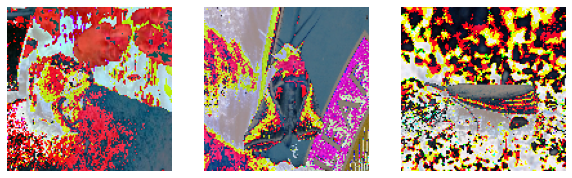

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
for i in range(3):
    batch=next(train_set)   
    img=batch[0][0]  
    image = img.astype('uint8')
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis('off')

## Importing and Modifying the ResNet50 model 

In [9]:
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(size,size,3),
    pooling="avg",
    classes=class_num
)

In [10]:
resnet.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [11]:
for layer in resnet.layers[:-5]:
    layer.trainable = False

## Building the Classification Model 

In [12]:
resnet_model = Sequential()

resnet_model.add(resnet)
resnet_model.add(Flatten())

resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(class_num, activation='softmax',name='output'))

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 3)                 3

In [14]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [15]:
ResNetModel = resnet_model.fit(
    train_set,
    validation_data=test_set,
    epochs=20
)

Epoch 1/20
90/90 [==============================] - 116s 1s/step - loss: 0.6394 - accuracy: 0.7681 - val_loss: 0.3466 - val_accuracy: 0.9000
Epoch 2/20
90/90 [==============================] - 68s 752ms/step - loss: 0.3393 - accuracy: 0.8816 - val_loss: 0.3155 - val_accuracy: 0.9125
Epoch 3/20
90/90 [==============================] - 76s 844ms/step - loss: 0.2442 - accuracy: 0.9125 - val_loss: 0.2656 - val_accuracy: 0.9208
Epoch 4/20
90/90 [==============================] - 75s 837ms/step - loss: 0.1709 - accuracy: 0.9316 - val_loss: 0.3041 - val_accuracy: 0.9069
Epoch 5/20
90/90 [==============================] - 74s 818ms/step - loss: 0.1362 - accuracy: 0.9524 - val_loss: 0.2934 - val_accuracy: 0.9139
Epoch 6/20
90/90 [==============================] - 73s 806ms/step - loss: 0.0913 - accuracy: 0.9677 - val_loss: 0.5457 - val_accuracy: 0.8833
Epoch 7/20
90/90 [==============================] - 74s 822ms/step - loss: 0.1069 - accuracy: 0.9642 - val_loss: 0.4459 - val_accuracy: 0.8875
E

In [16]:
resnet_model.save("Animal_Classifier.h5")

## 

## Model Evaluation -> Accuracy, F1 Score, Precision, Recall, Confusion Matrix, etc 

In [17]:
train_loss, train_acc = resnet_model.evaluate(train_set)

90/90 [==============================] - 54s 599ms/step - loss: 0.0092 - accuracy: 0.9962


In [18]:
test_loss, test_acc = resnet_model.evaluate(test_set)

23/23 [==============================] - 14s 603ms/step - loss: 0.5909 - accuracy: 0.9056


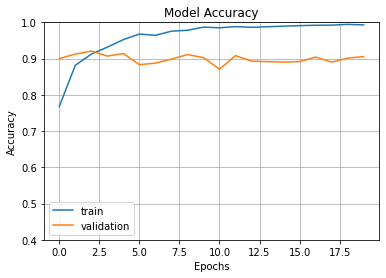

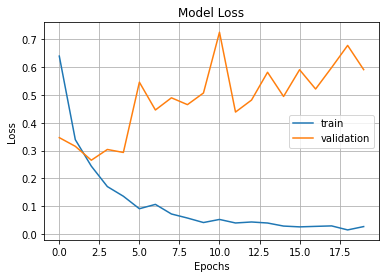

In [19]:
fig1 = plt.gcf()
plt.plot(ResNetModel.history['accuracy'])
plt.plot(ResNetModel.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(ResNetModel.history['loss'])
plt.plot(ResNetModel.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [20]:
prediction = resnet_model.predict(test_set) 
resnet_classes=np.argmax(prediction,axis=1)

23/23 [==============================] - 15s 619ms/step


In [21]:
test_labels = test_set.classes

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, resnet_classes))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       240
           1       0.87      0.90      0.89       240
           2       0.95      0.95      0.95       240

    accuracy                           0.91       720
   macro avg       0.91      0.91      0.91       720
weighted avg       0.91      0.91      0.91       720



<Axes: >

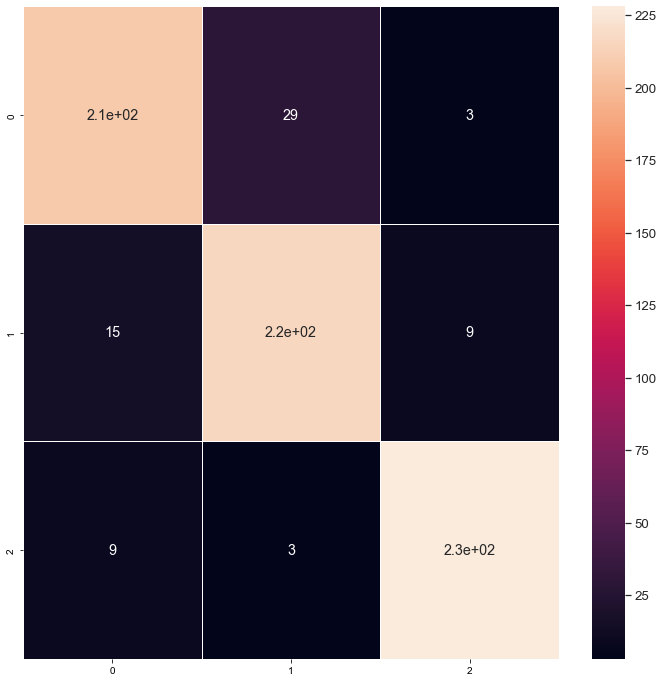

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, resnet_classes)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### 

## Classifications

In [28]:
import glob

class_names = []

for directory in glob.glob("D:/Tasks/Animal_Classification/dataset/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['Frog', 'Lizard', 'Moths']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 128, 128, 3)
(128, 128, 3)
Predicted Label:  Frog
True Label:  Frog


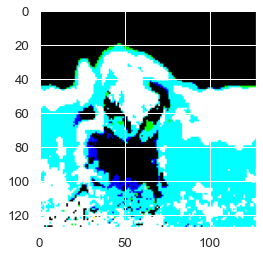

In [31]:
i = 20

batch=next(test_set)  
print(batch[0].shape) 
img=batch[0][i]  
print (img.shape)
plt.imshow(img) 


print("Predicted Label: ", class_names[int(resnet_classes[i])])
print("True Label: ", class_names[int(test_labels[i])])

## 

In [35]:
resnet_model = tf.keras.models.load_model('D:/Tasks/Animal_Classification/API - Animal_Classifier/Animal_Classifier.h5')

1/1 [==============================] - 1s 1s/step
[[1.9834814e-28 1.0000000e+00 3.3643695e-32]]
[1]
1
Classification:  Lizard


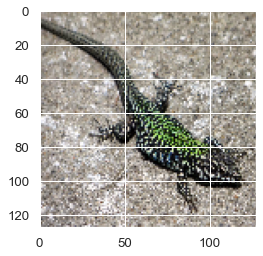

In [36]:
image_path = "D:/Tasks/Animal_Classification/dataset/089deaa014d1adc3.jpg"

test_img = tf.keras.utils.load_img(image_path, target_size = (size, size)) 
test_image = tf.keras.utils.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
test_image = tf.keras.applications.resnet50.preprocess_input(test_image)
    
result = resnet_model.predict(test_image)

print(result)
print(np.argmax(result,axis=1))
print(int(np.argmax(result,axis=1)))

plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])